# Roughness Estimation of the Russian Stock Market in the Context of the Rough Fractional Stochastic Volatility Model

Author:  Artemy Sazonov, Group 309, Faculty of Mechanics and Mathematics, Probability Department

## Libs and Constants

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import normaltest


import yfinance as yf

from ipywidgets import interact
from ipywidgets import widgets

from dataclasses import dataclass, field
from typing import Union
from copy import deepcopy

In [4]:
num_of_q      = 5
minutes_count = 15
days_count    = 10
step_of_q     = 0.3
sD            = 1
pD            = 40

In [5]:
RX_Equities = np.array(["YNDX RX Equity", 
                        "SBER RX Equity", 
                        "VTBR RX Equity", 
                        "MOEX RX Equity", 
                        "LKOH RX Equity", 
                        "GAZP RX Equity", 
                        "FIVE RX Equity"])

LI_Equities = np.array(["OGZD LI Equity", 
                        "VTBR LI Equity", 
                        "SBER LI Equity", 
                        "LKOD LI Equity"])
                        
Equities    = np.concatenate((RX_Equities, LI_Equities))

## Estimation

### Hurst Parameter Estimation

In [6]:
def m(q, Delta, volatility_array):
    retval = 0
    N = volatility_array.size-Delta

    for i in range(0, N, Delta):
        retval += pow(abs(math.log(volatility_array[i+Delta]/volatility_array[i])), q)

    retval /= int(volatility_array.size/Delta)
    return retval

def ACov(volatility_array, Delta):
    retval = 0
    N = volatility_array.size - Delta

    if N < 1:
        return 0

    for i in range(0, N):
        retval+= volatility_array[i]*volatility_array[i+Delta]

    retval /= N
    return math.log(retval)

def logCov(volatility_array, Delta):
    IID = 0.0
    I   = 0.0
    ID  = 0.0
    N   = volatility_array.size - Delta
    volatility_array = np.log(volatility_array)

    if N < 1:
        return 0

    for i in range(0, N):
        IID+= volatility_array[i]*volatility_array[i+Delta]
        I  += volatility_array[i]
        ID += volatility_array[i+Delta]

    IID /= N
    I   /= N
    ID  /= N

    return math.log(IID - I*ID)
    
def skew(x1, x2, y1, y2):
    return (y2 - y1) / (x2 - x1)

def rlz_vol_est(df: pd.DataFrame, count: int, rolling_window: int=1) -> np.ndarray:
    log_returns = np.zeros(int(df.shape[0]/rolling_window))
    for i in range(1, log_returns.size):
        log_returns[i] = math.log(df["Mean"][i*rolling_window]/df["Mean"][(i-1)*rolling_window])

    rlz_vol = np.zeros(int(log_returns.size/count))

    for i in range(rlz_vol.size):
        lr_n = np.zeros(count)
        for n in range(count):
            lr_n[n] = log_returns[i*count+n]

        tmp = 0.0
        for j in range(1, lr_n.size):
            tmp += (lr_n[j] - lr_n[j-1])**2

        rlz_vol[i] = math.sqrt(tmp)

    return rlz_vol

def excessed_kurtosis(X: np.ndarray) -> float:
    X = (X-np.mean(X))/np.std(X)
    return np.mean(X**4)-3

In [1]:
def analyse_volatility(name: str, mode: str='yf', rolling_window: int=1, show_pics = True, save_pics = False, smoothing: bool = False):
    if mode == 'yf':
        count = days_count
        df = yf.download(name, '2000-01-01', '2019-01-01')
        df["Mean"] = 0.5*(df["Open"]+df["Close"])

    elif mode == 'bb':
        count = minutes_count
        df = pd.read_csv('data_bloomberg/'+name+'.csv', sep="\t")  
        df["Mean"] = 0.5*(df["High"]+df["Low"])

    if smoothing:
        show_pics = False
        save_pics = False
    
    if show_pics:
        print("Report on " + name)

    volatility_array = rlz_vol_est(df, count, rolling_window=rolling_window)
    zetaq            = np.zeros((2, num_of_q))

    if show_pics:
        figsize = (21, 29)
        fig, ax = plt.subplots(3, 3, figsize = figsize)
        if mode == 'yf':
            vol_time = np.arange(1, volatility_array.size+1, 1)
        elif mode == 'bb':
            vol_time = np.arange(volatility_array.size, 0, -1)
        ax[0, 0].plot(vol_time, volatility_array)
        ax[0, 0].set_xlabel("Time")
        ax[0, 0].set_ylabel("Realized volatility")

    for I in range(0, num_of_q):
        graph_data = np.zeros((2, pD-sD))
        q          = step_of_q*(1+I)
        line_start = math.log(sD)
        line_stop  = math.log(pD)
        
        for Delta in range(sD, pD):
            graph_data[0, Delta-sD] = math.log(Delta)
            graph_data[1, Delta-sD] = math.log(m(q, Delta, volatility_array))

        linear_model    = np.polyfit(graph_data[0],graph_data[1], 1)
        linear_model_fn = np.poly1d(linear_model)
        x_s             = np.arange(line_start, line_stop, 0.1)

        if show_pics:
            ax[0, 1].plot(x_s, linear_model_fn(x_s))
            ax[0, 1].scatter(graph_data[0], graph_data[1], label=str(round(q, 2)))

        skew_of_linear_model = skew(line_start, line_stop, linear_model_fn(line_start), linear_model_fn(line_stop))

        zetaq[0, I] = q
        zetaq[1, I] = skew_of_linear_model

    if show_pics:
        ax[0, 1].set_xlabel("$\log \Delta$")
        ax[0, 1].set_ylabel("$\log m$")
        ax[0, 1].legend()
    
    linear_model_H    = np.polyfit(zetaq[0], zetaq[1], 1)
    linear_model_H_fn = np.poly1d(linear_model_H)
    x_s               = np.arange(0, step_of_q*(num_of_q+1), step_of_q)

    if show_pics:
        ax[0, 2].plot(x_s, linear_model_H_fn(x_s), color="red")
        ax[0, 2].scatter(zetaq[0], zetaq[1])
        ax[0, 2].set_xlabel("$q$")
        ax[0, 2].set_ylabel("$\zeta_q$")

    H_est = skew(0, step_of_q*(num_of_q)+1, linear_model_H_fn(0), linear_model_H_fn(step_of_q*(num_of_q)+1))

    if smoothing:
        return H_est

    if show_pics:
        print("Estimated H parameter for " + name + " is equal to " + str(H_est))

    sz = 40
    graph_data = np.zeros((2, sz))

    for Delta in range(1, sz+1):
        graph_data[0, Delta-1] = Delta**(2*H_est)
        graph_data[1, Delta-1] = ACov(volatility_array, Delta)

    linear_model    = np.polyfit(graph_data[0],graph_data[1], 1)
    linear_model_fn = np.poly1d(linear_model)
    x_s             = np.arange(1, (sz+1)**(2*H_est), 0.1)

    if show_pics:
        ax[1, 0].plot(x_s, linear_model_fn(x_s), color="red")
        ax[1, 0].scatter(graph_data[0], graph_data[1])
        ax[1, 0].set_xlabel("$\Delta^{ 2H }$")
        ax[1, 0].set_ylabel("$\log E[\sigma_t \sigma_{t+\Delta}]$")

    for Delta in range(1, sz+1):
        graph_data[0, Delta-1] = math.log(Delta)
        graph_data[1, Delta-1] = logCov(volatility_array, Delta)

    linear_model    = np.polyfit(graph_data[0],graph_data[1], 1)
    linear_model_fn = np.poly1d(linear_model)
    x_s             = np.arange(0, math.log(sz+1), 0.1)

    if show_pics:
        if not save_pics:
            fig.suptitle(name)
        ax[1, 1].plot(x_s, linear_model_fn(x_s), color="red")
        ax[1, 1].scatter(graph_data[0], graph_data[1])
        ax[1, 1].set_xlabel("$\log \Delta$")
        ax[1, 1].set_ylabel("$\log Cov[\sigma_t, \sigma_{t+\Delta}]$")
        
    def lag_array(Delta):
        retarr = np.zeros(volatility_array.size - Delta) 
        if Delta >= 0:
            for i in range(0, volatility_array.size-Delta):
                retarr[i] = np.log(volatility_array[i+Delta]) - np.log(volatility_array[i])
        else:
            for i in range(0, volatility_array.size-math.abs(Delta)):
                retarr[i] = np.log(volatility_array[i]) - np.log(volatility_array[i-Delta])

        retarr = retarr/retarr.max()
        return retarr           

    if show_pics:
        bins_num  = 100
        X         = np.linspace(-2, 2, 500)
        indices1  = np.array([1, 2, 2, 2])
        indices2  = np.array([2, 0, 1, 2])
        Deltas    = np.array([1, 5, 10, 20])
        stdla1    = np.std(lag_array(1))
        for i in range(0, 4):
            la = lag_array(Deltas[i])
            ax[indices1[i], indices2[i]].hist(la, bins = bins_num, density = True, label='Emprirical density')
            sns.kdeplot(la, label='KDE', ax = ax[indices1[i], indices2[i]])
            ax[indices1[i], indices2[i]].set_title("Density of $\log \sigma_{ t+\Delta} - \log \sigma_{ t}$ with 1 day lag, $\kappa = $" + str(round(excessed_kurtosis(la), 3)))
            ax[indices1[i], indices2[i]].plot(X, norm.pdf(X, 0, np.std(la)), color="red", label="Normal fit")
            ax[indices1[i], indices2[i]].plot(X, norm.pdf(X, 0, stdla1*Deltas[i]**H_est), color="green", label="Empirical fit")
            ax[indices1[i], indices2[i]].legend()

        for i in range(3):
            for j in range(3):
                ax[i, j].grid(True)
            
        if save_pics:
            plt.savefig("fig/" + name + ".pdf")
        
        plt.show()
        
    curt_range = 50
    curt_array = np.zeros(curt_range)

    def normality_table_LaTeX():
        with open("tab/Normality tests " + name + ".tex", "w") as f:
            f.write('\\begin{table}[h]\n')
            f.write('\t\\begin{tabular}{|c|c|c|c|c|c|}\n')
            f.write('\t\t\\hline\n')
            f.write('\t\t$\Delta$ &  Shapiro-Wilk (stat) & Shapiro-Wilk (p-value) & $K^2$ (stat) & $K^2$ (p-value) & Conclusion\\\\\\hline\n\t\t\\hline\n')
            
            for i in range(1, curt_range):
                la = lag_array(i)
                curt_array[i-1] = excessed_kurtosis(la)
                statSW, pSW = shapiro(la)
                statK2, pK2 = normaltest(la)
                alpha = 0.05
                if pSW > alpha or pK2 > alpha:
                    conclusion = "Normal"
                else:
                    conclusion = "Not normal"
            
                f.write('\t\t' + str(i) + ' & ' + str(format(statSW,'.5E')) + ' & ' + str(format(pSW,'.3E')) + ' & ' + str(format(statK2,'.5E'))+ ' & ' + str(format(pK2,'.3E')) + ' & ' + conclusion +'\\\\\\hline\n')
            f.write('\t\\end{tabular}\n')
            f.write('\t\\caption{Normality tests for ' + name + '}\n')
            f.write('\t\\label{tab:normality_tests_' + name.split(" ")[0] + "_" + name.split(" ")[1] + '}\n')
            f.write('\\end{table}\n')

    normality_table_LaTeX()

    return H_est

In [6]:
def rw_H(rolling_window: int, name: str):
    H = analyse_volatility(name, mode='bb', rolling_window=rolling_window)

#### Service Methods

In [7]:
# Same as analyse_volatility method, only for multiple pictures output
def analyse_volatility_multipic(name: str, mode: str='yf', rolling_window: int=1, show_pics = True, save_pics = False):
    if mode == 'yf':
        count = days_count
        df = yf.download(name, '2000-01-01', '2019-01-01')
        df["Mean"] = 0.5*(df["Open"]+df["Close"])

    elif mode == 'bb':
        count = minutes_count
        df = pd.read_csv('data_bloomberg/'+name+'.csv', sep="\t")  
        df["Mean"] = 0.5*(df["High"]+df["Low"])


    if show_pics:
        print("Report on " + name)

    volatility_array = rlz_vol_est(df, count, rolling_window=rolling_window)
    zetaq            = np.zeros((2, num_of_q))

    if show_pics:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 7), sharex=True)
        if mode == 'yf':
            sto_time = np.arange(1, df["Mean"].size+1, 1)
            vol_time = np.arange(1, volatility_array.size+1, 1)
        elif mode == 'bb':
            sto_time = np.arange(df["Mean"].size, 0, -1)
            vol_time = np.arange(volatility_array.size, 0, -1)

        ax1.plot(sto_time, df["Mean"])
        ax1.set_ylabel("Price, RUB")

        ax2.plot(vol_time*15, volatility_array)
        ax2.set_xlabel("Time (minutes)")
        ax2.set_ylabel("RV")

        if save_pics:
            plt.savefig("fig/" + name + " RVol.pdf")

        plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    
    for I in range(0, num_of_q):
        graph_data = np.zeros((2, pD-sD))
        q          = step_of_q*(1+I)
        line_start = math.log(sD)
        line_stop  = math.log(pD)
        
        for Delta in range(sD, pD):
            graph_data[0, Delta-sD] = math.log(Delta)
            graph_data[1, Delta-sD] = math.log(m(q, Delta, volatility_array))

        linear_model    = np.polyfit(graph_data[0],graph_data[1], 1)
        linear_model_fn = np.poly1d(linear_model)
        x_s             = np.arange(line_start, line_stop, 0.1)

        if show_pics:
            ax1.plot(x_s, linear_model_fn(x_s))
            ax1.scatter(graph_data[0], graph_data[1], label=str(round(q, 2)))

        skew_of_linear_model = skew(line_start, line_stop, linear_model_fn(line_start), linear_model_fn(line_stop))

        zetaq[0, I] = q
        zetaq[1, I] = skew_of_linear_model


    if show_pics:
        ax1.set_xlabel("$\log \Delta$")
        ax1.set_ylabel("$\log m$")
        ax1.legend()
    
    linear_model_H    = np.polyfit(zetaq[0], zetaq[1], 1)
    linear_model_H_fn = np.poly1d(linear_model_H)
    x_s               = np.arange(0, step_of_q*(num_of_q+1), step_of_q)

    if show_pics:
        ax2.plot(x_s, linear_model_H_fn(x_s), color="red")
        ax2.scatter(zetaq[0], zetaq[1])
        ax2.set_xlabel("$q$")
        ax2.set_ylabel("$\zeta_q$")

        if save_pics:
            plt.savefig("fig/" + name + " Hurst Est.pdf")

        plt.show()

    H_est = skew(0, step_of_q*(num_of_q)+1, linear_model_H_fn(0), linear_model_H_fn(step_of_q*(num_of_q)+1))

    sz = 30
    graph_data = np.zeros((2, sz))

    for Delta in range(1, sz+1):
        graph_data[0, Delta-1] = Delta**(2*H_est)
        graph_data[1, Delta-1] = ACov(volatility_array, Delta)

    linear_model    = np.polyfit(graph_data[0],graph_data[1], 1)
    linear_model_fn = np.poly1d(linear_model)
    x_s             = np.arange(1, (sz+1)**(2*H_est), 0.1)

    if show_pics:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

        ax1.plot(x_s, linear_model_fn(x_s), color="red")
        ax1.scatter(graph_data[0], graph_data[1])
        ax1.set_xlabel("$\Delta^{ 2H }$")
        ax1.set_ylabel("$\log E[\sigma_t \sigma_{t+\Delta}]$")

            
    for Delta in range(1, sz+1):
        graph_data[0, Delta-1] = math.log(Delta)
        graph_data[1, Delta-1] = logCov(volatility_array, Delta)

    linear_model    = np.polyfit(graph_data[0],graph_data[1], 1)
    linear_model_fn = np.poly1d(linear_model)
    x_s             = np.arange(0, math.log(sz+1), 0.1)

    if show_pics:
        ax2.plot(x_s, linear_model_fn(x_s), color="red")
        ax2.scatter(graph_data[0], graph_data[1])
        ax2.set_xlabel("$\log \Delta$")
        ax2.set_ylabel("$\log Cov[\sigma_t, \sigma_{t+\Delta}]$")

        if save_pics:
            plt.savefig("fig/" + name + " logE vs logD.pdf")
        plt.show()
        
    def lag_array(Delta):
        retarr = np.zeros(volatility_array.size - Delta) 
        if Delta >= 0:
            for i in range(0, volatility_array.size-Delta):
                retarr[i] = np.log(volatility_array[i+Delta]) - np.log(volatility_array[i])
        else:
            for i in range(0, volatility_array.size-math.abs(Delta)):
                retarr[i] = np.log(volatility_array[i]) - np.log(volatility_array[i-Delta])

        retarr = retarr/retarr.max()
        return retarr


    
    def normality_table_LaTeX():
        with open("tab/Normality tests " + name + " (cut).tex", "w") as f:
            f.write('\\begin{table}[h]\n')
            f.write('\t\\begin{tabular}{|c|c|c|c|c|c|}\n')
            f.write('\t\t\\hline\n')
            f.write('\t\t$\Delta$ &  Shapiro-Wilk (stat) & Shapiro-Wilk (p-value) & $K^2$ (stat) & $K^2$ (p-value) & Conclusion\\\\\\hline\n\t\t\\hline\n')
            
            stat_range = 30
            for i in range(1, stat_range+1):
                la = lag_array(i)

                statSW, pSW = shapiro(la)
                statK2, pK2 = normaltest(la)
                alpha = 0.05
                if pSW > alpha or pK2 > alpha:
                    conclusion = "Normal"
                else:
                    conclusion = "Not normal"
            
                f.write('\t\t' + str(i) + ' & ' + str(format(statSW,'.5E')) + ' & ' + str(format(pSW,'.3E')) + ' & ' + str(format(statK2,'.5E'))+ ' & ' + str(format(pK2,'.3E')) + ' & ' + conclusion +'\\\\\\hline\n')
            f.write('\t\\end{tabular}\n')
            f.write('\t\\caption{Normality tests for ' + name + '}\n')
            f.write('\t\\label{tab:normality_tests_' + name.split(" ")[0] + "_" + name.split(" ")[1] + '_cut}\n')
            f.write('\\end{table}\n')

    #normality_table_LaTeX()

    fig, axs = plt.subplots(2, 2, figsize = (16, 10), sharex=True, sharey=True)

    if show_pics:
        bins_num = 50
        Deltas = np.array([[1, 5], [10, 20]])
        X = np.linspace(-2, 2, 500)
        if not save_pics:
            fig.suptitle("Density of $\log \sigma_{t+\Delta} - \log \sigma_{t}$ for " + name)
        
        stdla1 = np.std(lag_array(Deltas[0][0]))
        for i in range(2):
            for j in range(2):
                la = lag_array(Deltas[i][j])
                axs[i, j].hist(la, bins = bins_num, density = True, label='Empirical density')
                sns.kdeplot(la, label='KDE', ax = axs[i, j])
                axs[i, j].plot(X, norm.pdf(X, 0, np.std(la)), color="red", label="Normal fit")
                axs[i, j].plot(X, norm.pdf(X, 0, stdla1*Deltas[i, j]**H_est), color="green", label="Empirical fit")
                axs[i, j].set_title("$\Delta = " + str(Deltas[i, j]) + "$")
                axs[i, j].legend()
                axs[i, j].grid()

        if save_pics:
            fig.savefig("fig/" + name + " " + str(Delta) + " Lag Hists.pdf")
        plt.show()

    if show_pics:
        curt_array = np.zeros(60)
        for i in range(1, 61):
            la = lag_array(i)
            curt_array[i-1] = excessed_kurtosis(la)
        plt.figure(figsize=(12, 5))
        plt.plot(np.arange(1, 61), curt_array, '-x')
        plt.xlabel("Lag (Days)")
        plt.ylabel("$\kappa$")
        plt.grid(True)
        if save_pics:
            plt.savefig("fig/" + name + " Excessed Curtosis.pdf")
        plt.show()
    

    return H_est

##### CSV

In [9]:
def export_report_as_csv(name: Union[str, np.ndarray], mode='bb'):
    t = time.localtime()
    current_time = time.strftime("%H-%M-%S", t)
    with open("report_" + str(current_time) +".csv", "x") as f:
        f.write("equity,H_est\n")
        for equity in name:
            f.write(str(equity)+','+str(round(analyse_volatility(equity, mode=mode, show_pics=False), 7))+'\n')

In [10]:
export_report_as_csv(Equities)

#### Report with Dynamic Rolling Window

In [11]:
interact(rw_H, rolling_window = widgets.FloatSlider(min=1, max=10, step=1, value=1, description='Rolling Window'),
               name           = widgets.Dropdown(options=Equities, value=Equities[0]))

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\traitlets.py:588: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(FloatSlider(value=1.0, description='Rolling Window', max=10.0, min=1.0, step=1.0), Dropd…

<function __main__.rw_H(rolling_window: int, name: str)>

### The Effect of Smoothing

In [9]:
H = analyse_volatility("YNDX RX Equity", mode='bb', rolling_window=1, show_pics=False)  

def f(theta):
    return (1/((2*H+1)*(2*H+2)*theta**2)*((1+theta)**(2*H+2) - 2 - 2 * theta**(2*H+2) + (1-theta)**(2*H+2)))    

def smoothing_theoretical(delta: float):
    num_of_Deltas = 200
    plot = np.zeros((2, num_of_Deltas))

    Delta = np.arange(1, num_of_Deltas+1, 1)
    plot[0] = np.log(Delta)
    plot[1] = np.log(Delta**(2*H) * f(delta/Delta))

    linear_model    = np.polyfit(plot[0],plot[1], 1)
    linear_model_fn = np.poly1d(linear_model)
    x_s             = np.arange(0, 5, 0.1)

    print(skew(0, 1, linear_model_fn(0), linear_model_fn(1))*0.5)
    print(skew(0, 1, linear_model_fn(0), linear_model_fn(1))*0.5/H - 1)


    plt.scatter(plot[0], plot[1])
    plt.plot(x_s, linear_model_fn(x_s))
    plt.xlabel("$\log \Delta$")
    plt.ylabel("$\Delta^{ 2H } f(\delta/\Delta)$")
    plt.title("Theoretical Estimation of Smoothing Effect for YNDX RX Equity")
    plt.show()

def smoothing_empirical(name: str, count: int, show_pics: bool=True, save_pics: bool=False):
    num_of_wind = minutes_count
    graph_data = np.zeros((2, num_of_wind))
    for i in range(1, num_of_wind+1):
        graph_data[0, i-1] = i
        graph_data[1, i-1] = analyse_volatility(name, mode='bb', rolling_window=i, smoothing = True)  

    a   = np.mean(graph_data[1])
    std = np.std(graph_data[1])
    min = np.min(graph_data[1])

    if show_pics:
        linear_model    = np.polyfit(graph_data[0], graph_data[1], 1)
        linear_model_fn = np.poly1d(linear_model)
        x_s             = np.arange(0, count, 0.1)

        plt.figure(figsize=(12, 5))
        plt.plot(x_s, linear_model_fn(x_s), color="red", label="Skew = " + str(round((linear_model_fn(count)-linear_model_fn(0))/count, 6)))

        plt.scatter(graph_data[0], graph_data[1])
        plt.xlabel("Rolling Window")
        plt.ylabel("H Estimate") 
        plt.legend()
        plt.grid(True)

        if save_pics:
            plt.savefig("fig/" + name + " Smoothing Effect.pdf")
        plt.show()

    return [a, std, min]

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Theoretical Est

In [13]:
interact(smoothing_theoretical, delta = widgets.FloatSlider(min=0.0001, max=1, step=0.00001, value=0.1, description='$\delta$'))

interactive(children=(FloatSlider(value=0.1, description='$\\delta$', max=1.0, min=0.0001, step=1e-05), Output…

<function __main__.smoothing_theoretical(delta: float)>

#### Empirical Est

In [14]:
interact(smoothing_empirical, count     = minutes_count, 
                              name      = widgets.Dropdown(options=Equities, value=Equities[0]),
                              show_pics = True, 
                              save_pics = False)

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\traitlets.py:588: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='name', options=('YNDX RX Equity', 'SBER RX Equity', 'VTBR RX Equit…

<function __main__.smoothing_empirical(name: str, count: int, show_pics: bool = True, save_pics: bool = False)>

## Report

### Analysis of the underlying assets

In [ ]:
analyse_volatility_multipic(Equities[0], mode='bb', save_pics=True)

Report on YNDX RX Equity
Estimated H parameter for YNDX RX Equity is equal to 0.052176564970241854


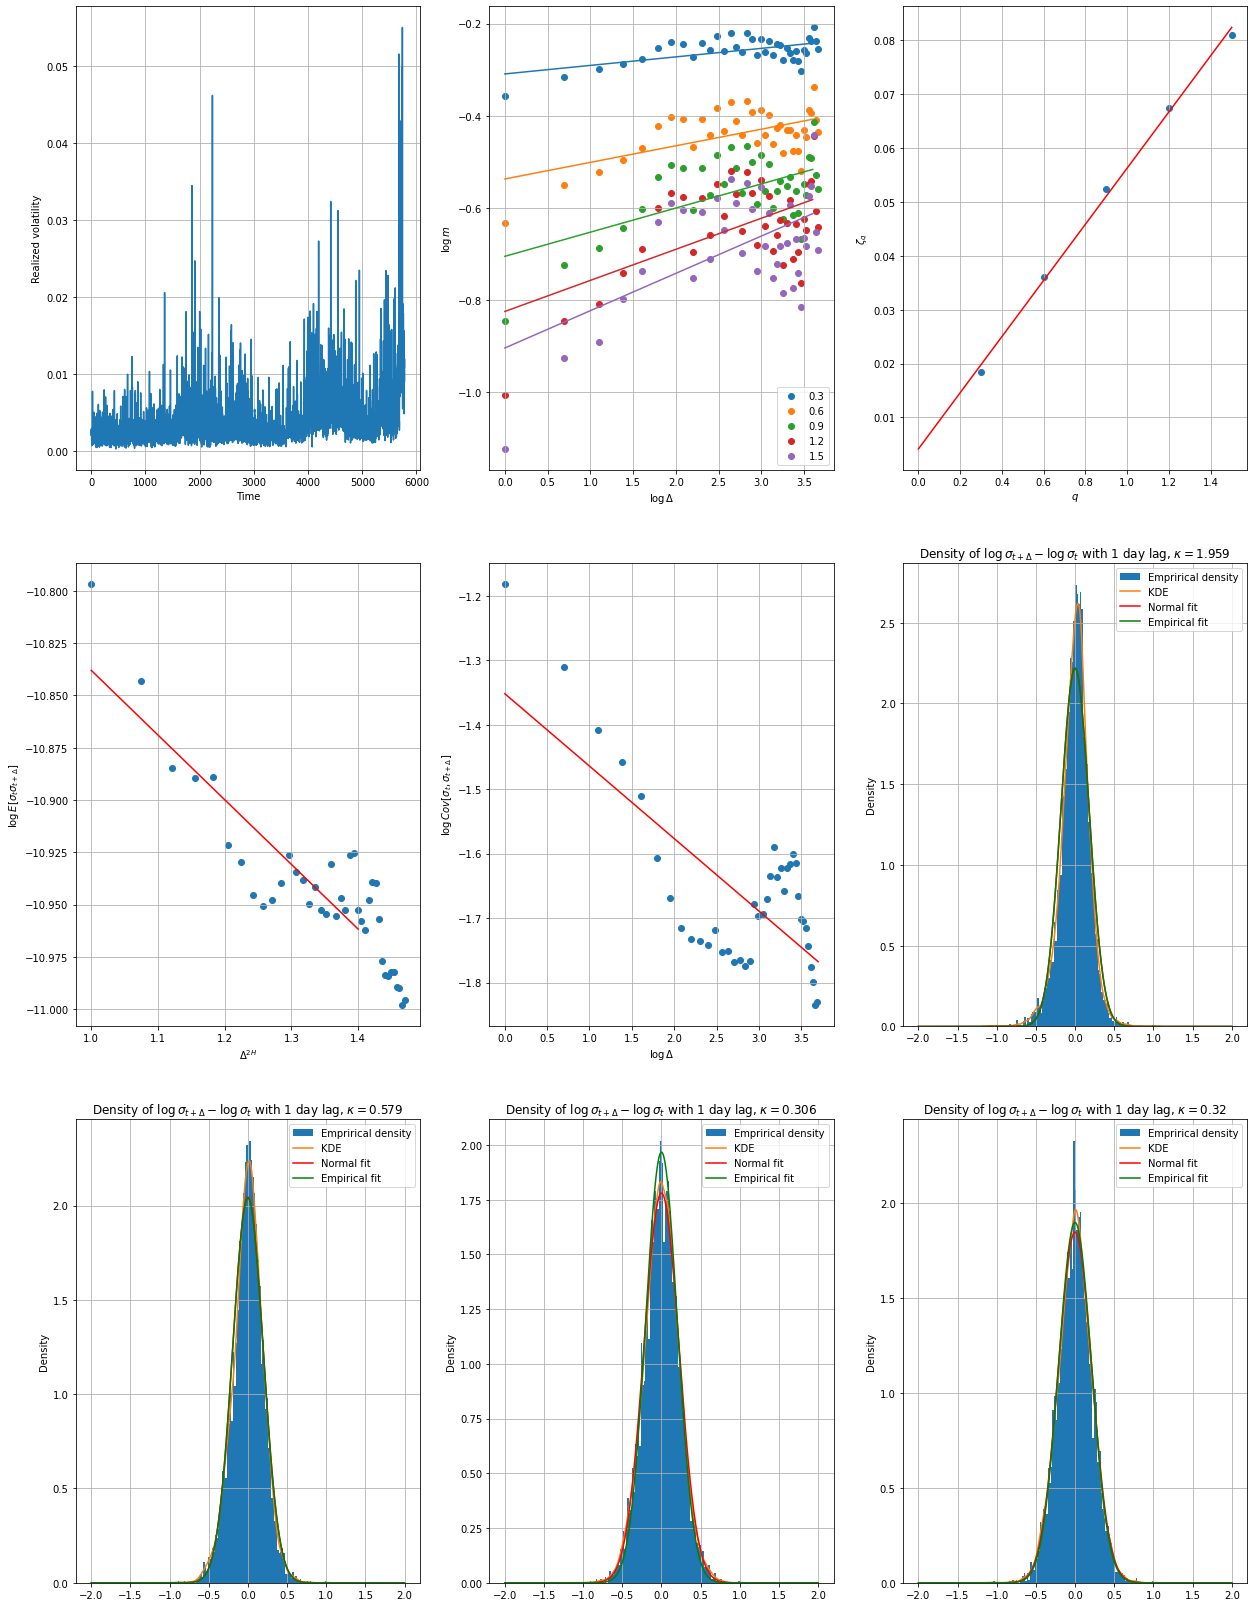

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on SBER RX Equity
Estimated H parameter for SBER RX Equity is equal to 0.15516463983649617


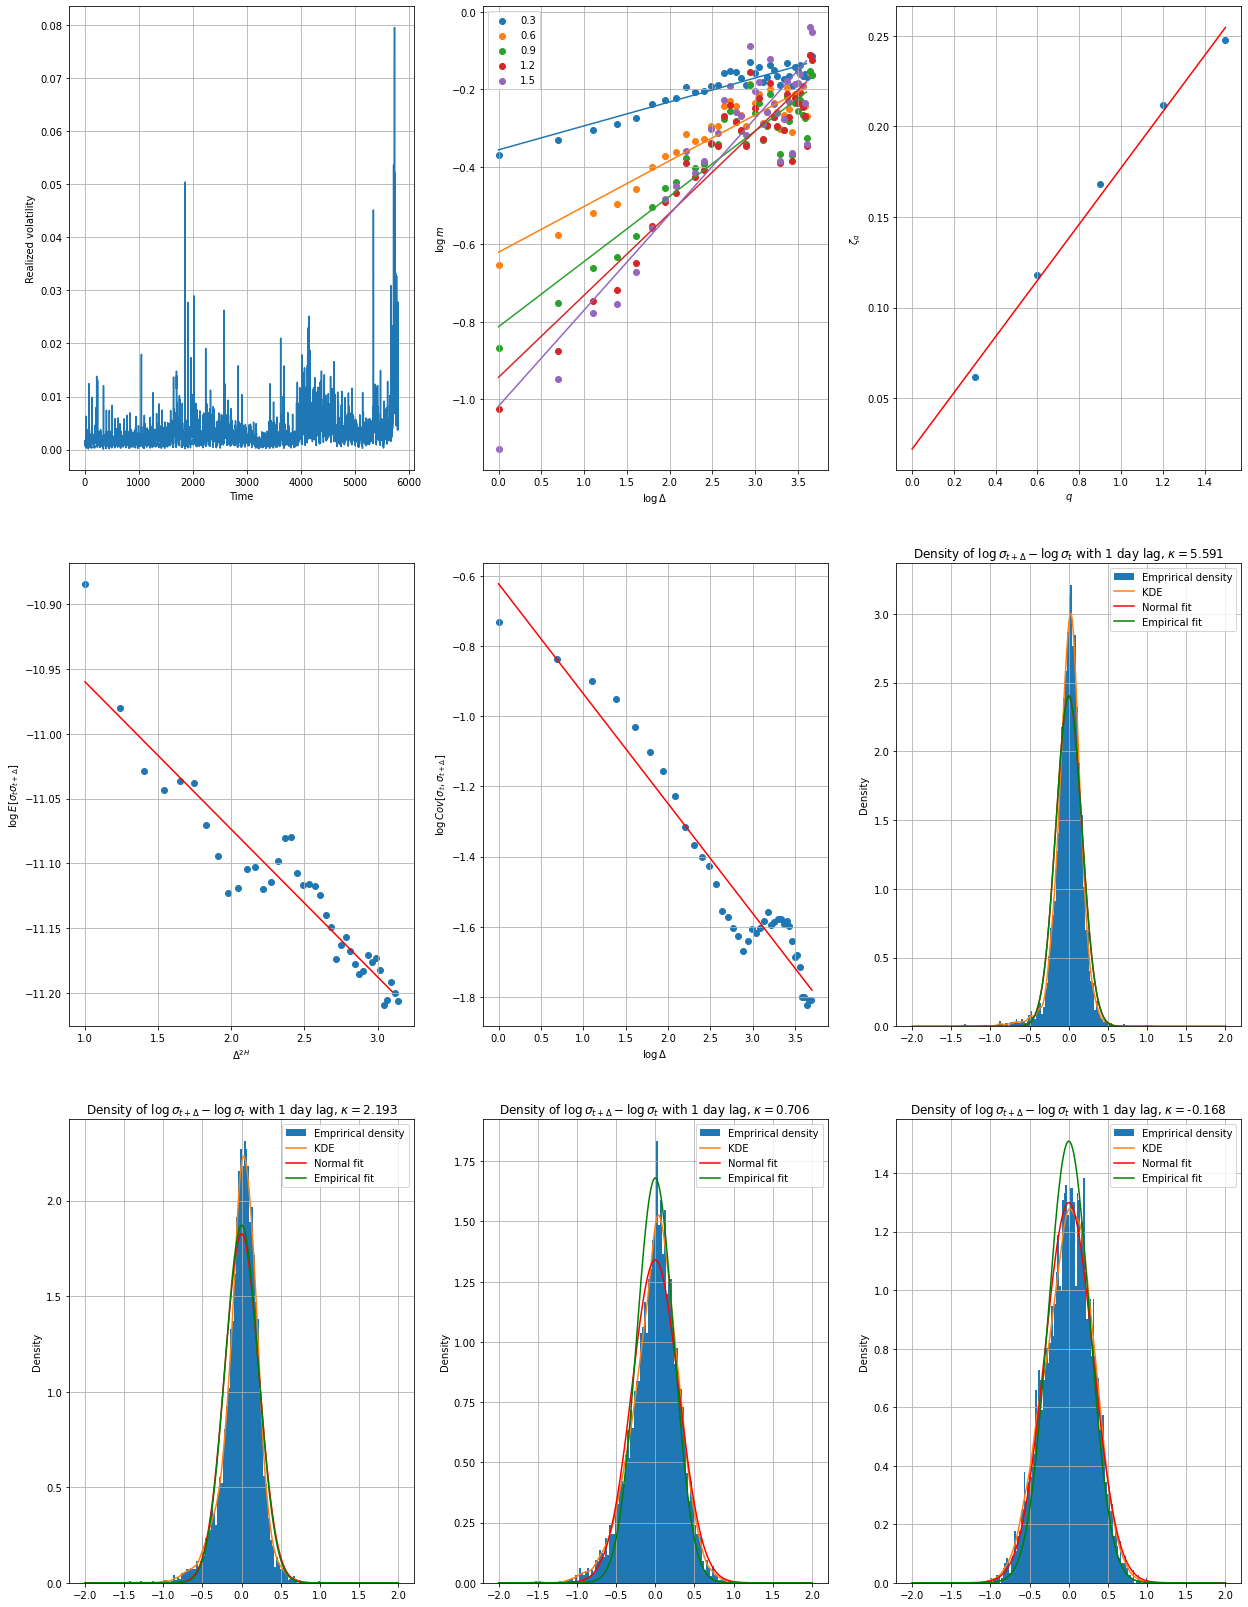

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on VTBR RX Equity
Estimated H parameter for VTBR RX Equity is equal to 0.09172363327636236


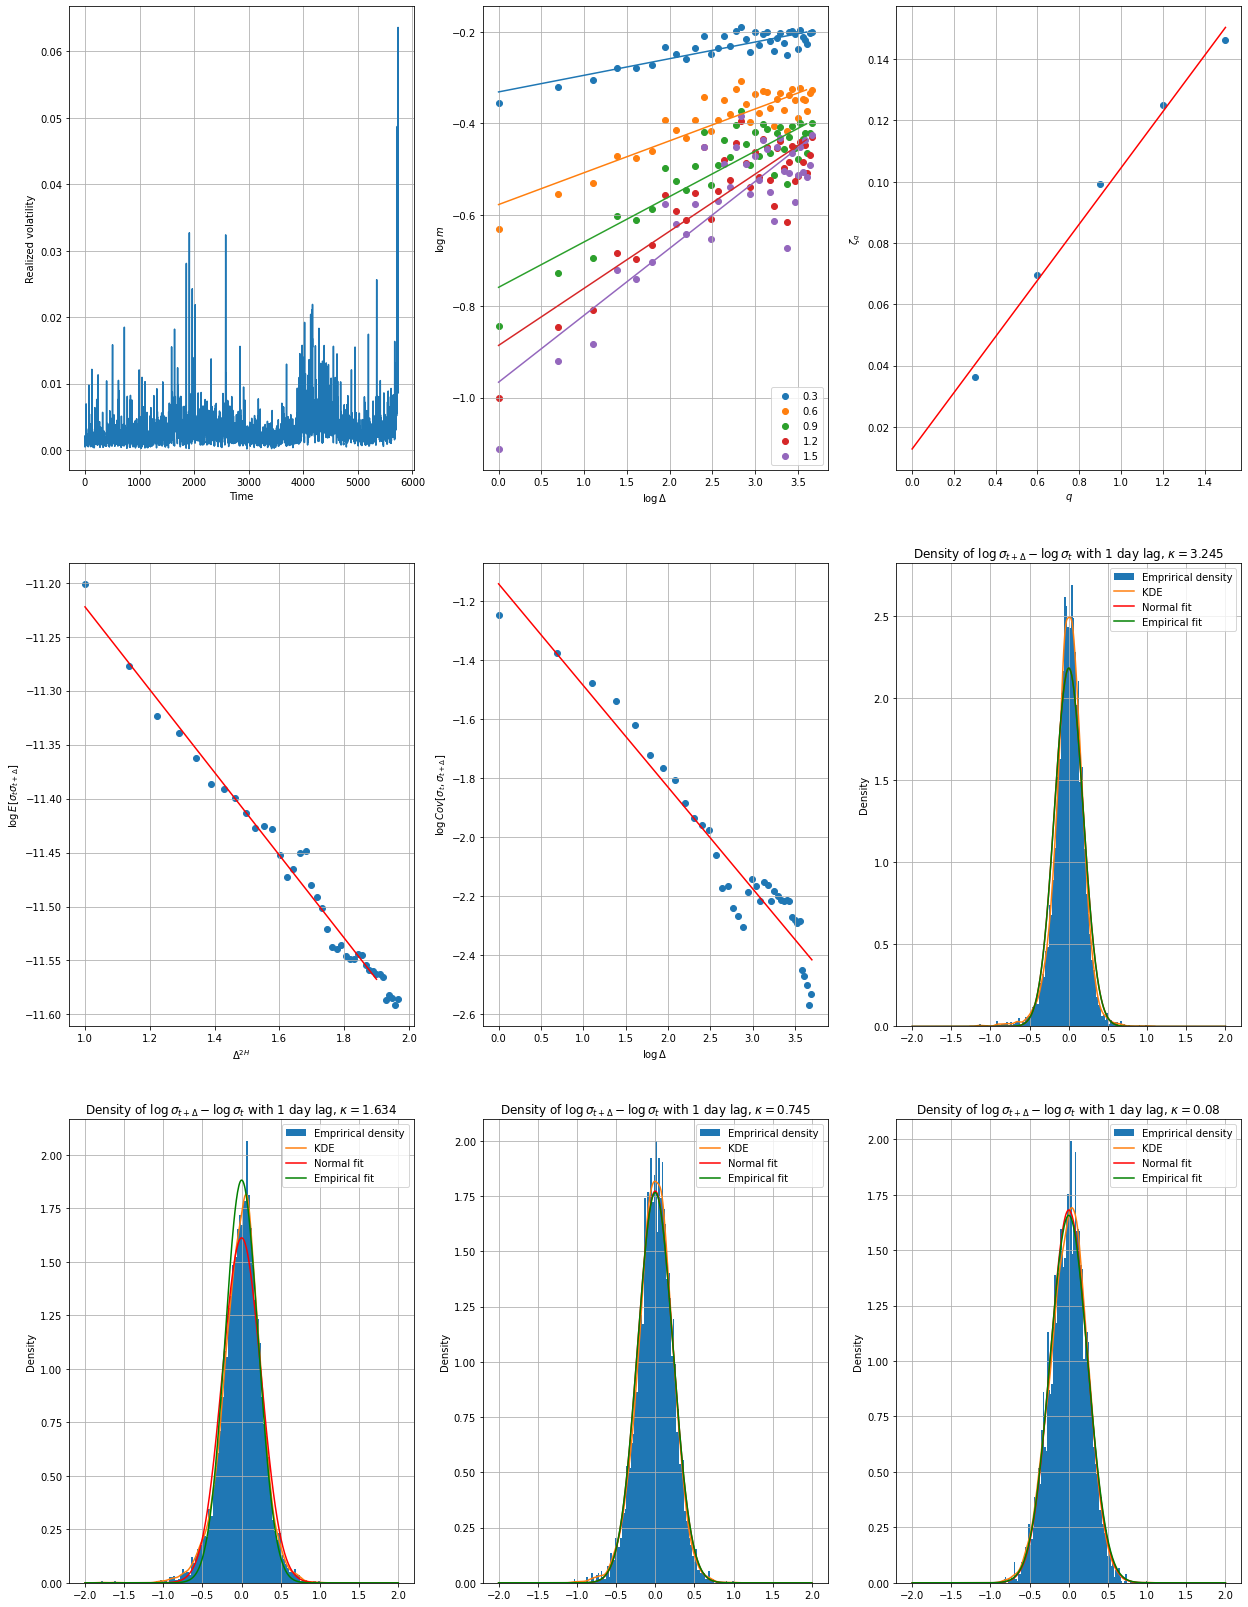

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on MOEX RX Equity
Estimated H parameter for MOEX RX Equity is equal to 0.08538775081748264


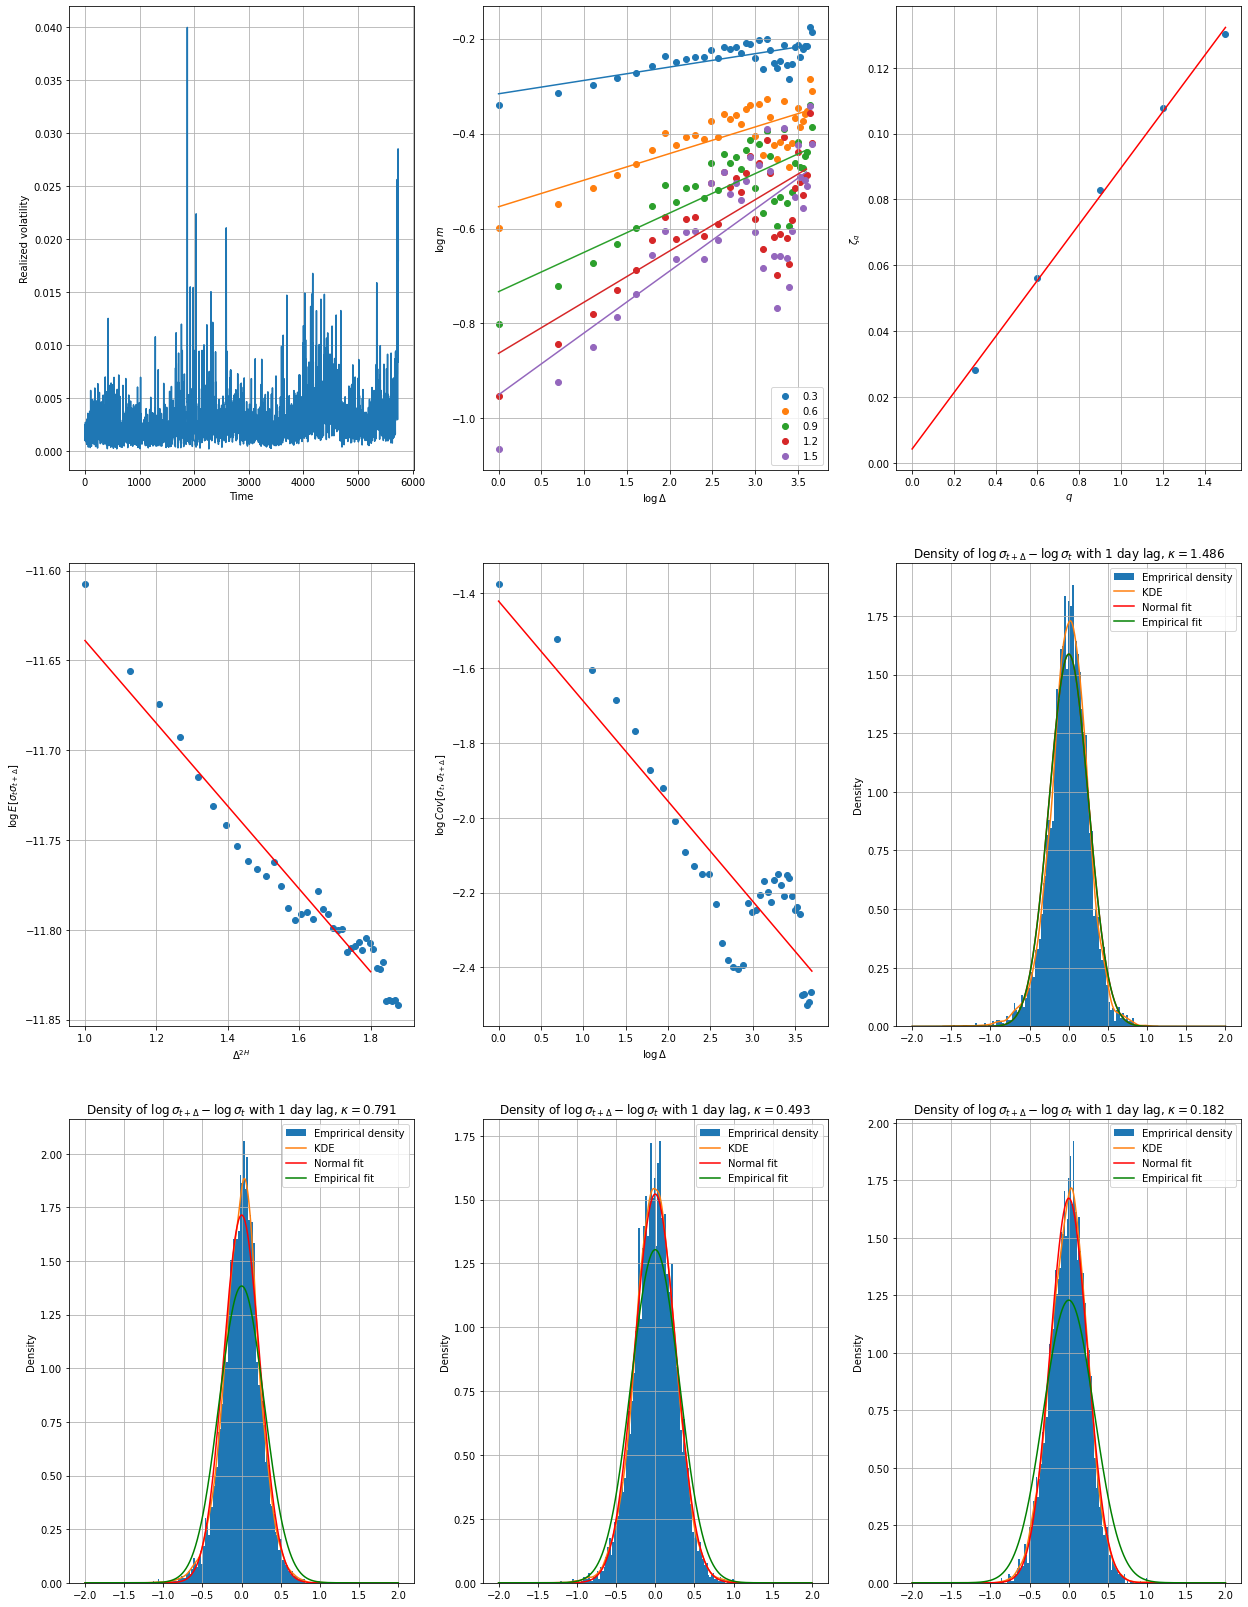

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on LKOH RX Equity
Estimated H parameter for LKOH RX Equity is equal to 0.07305206295787617


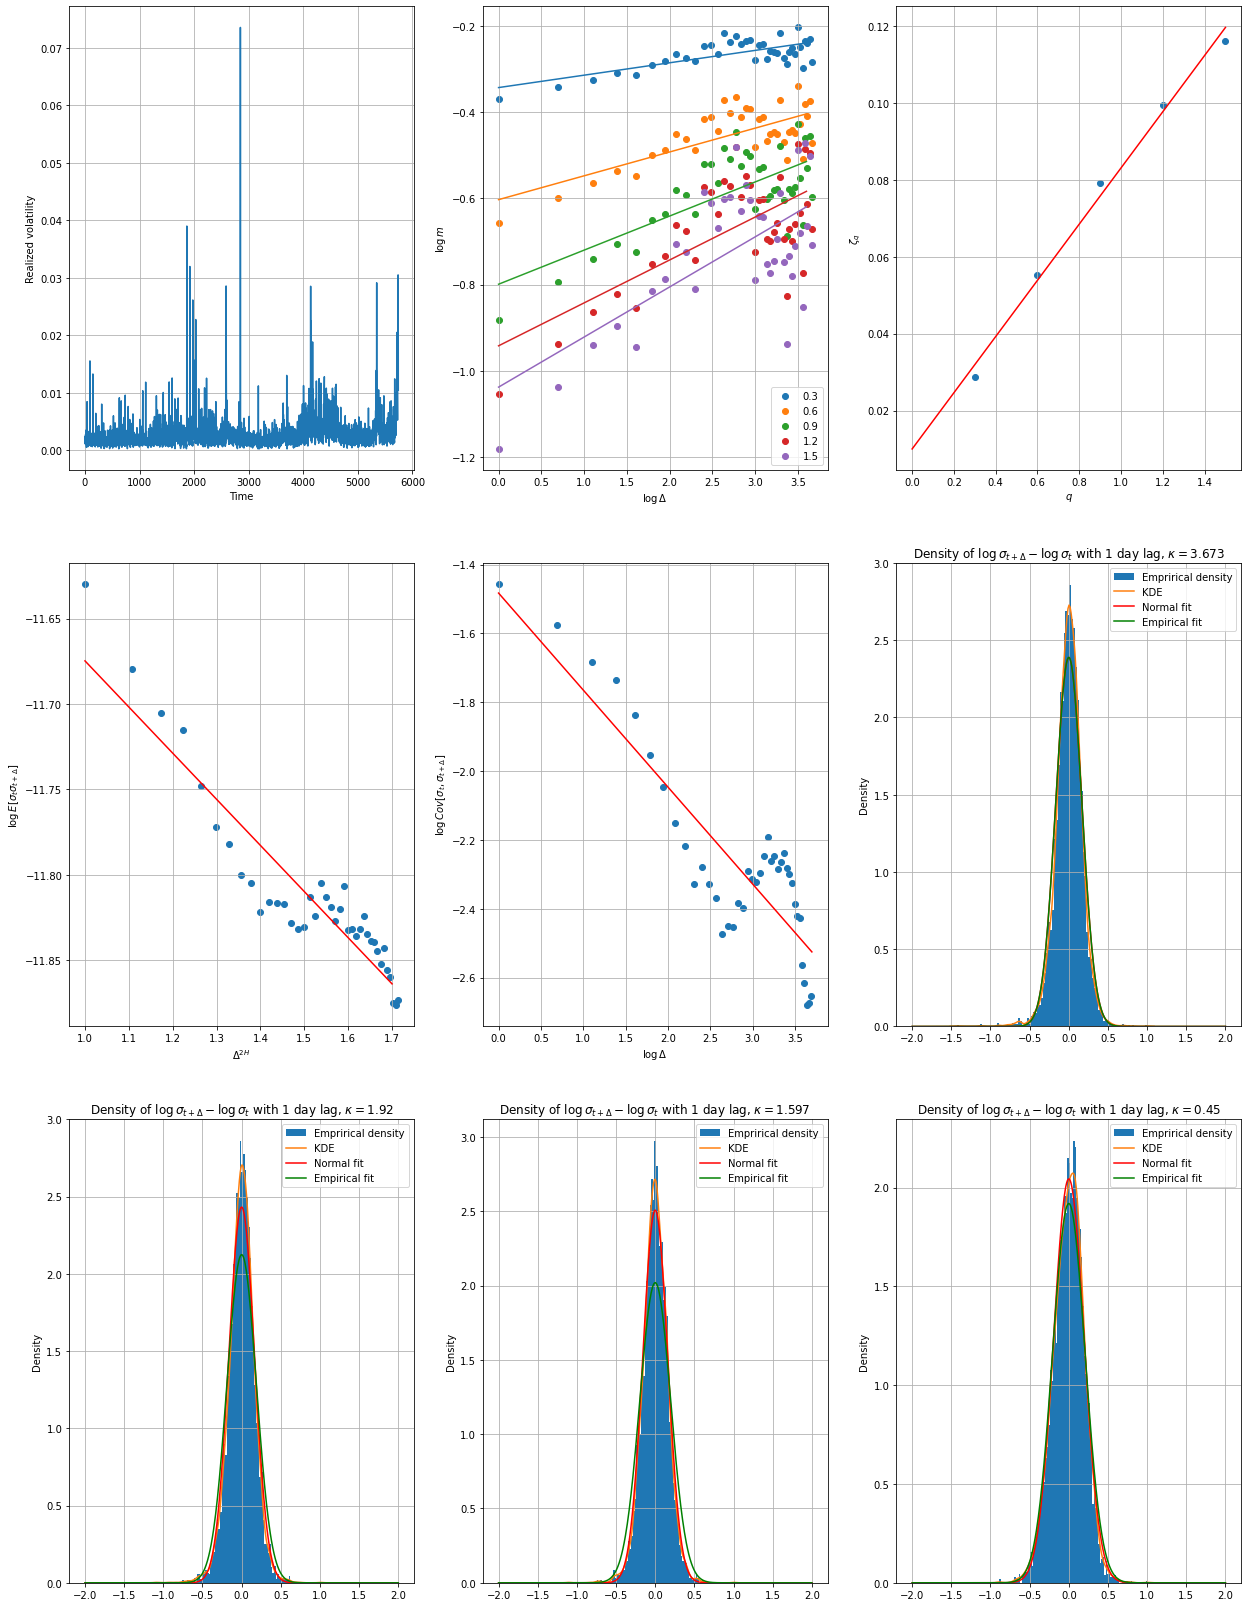

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on GAZP RX Equity
Estimated H parameter for GAZP RX Equity is equal to 0.13097047504739714


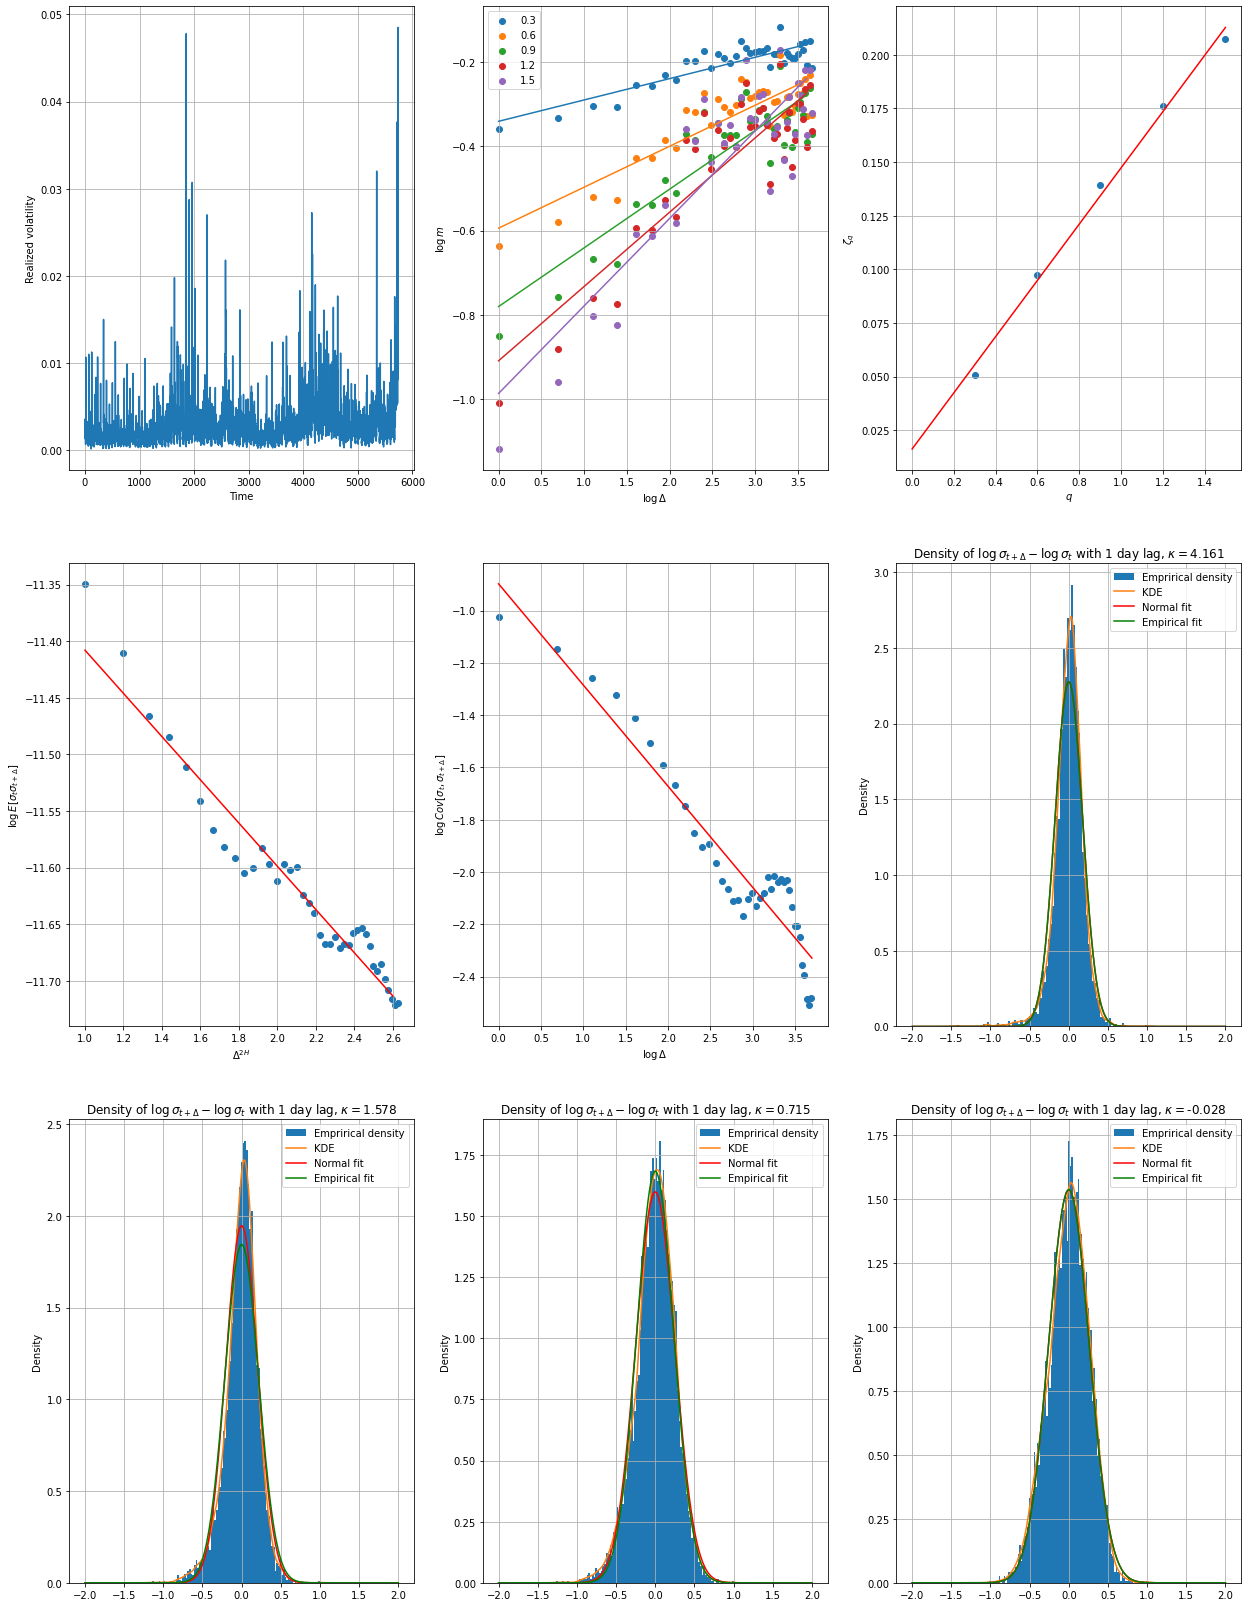

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on FIVE RX Equity
Estimated H parameter for FIVE RX Equity is equal to 0.0630289326675853


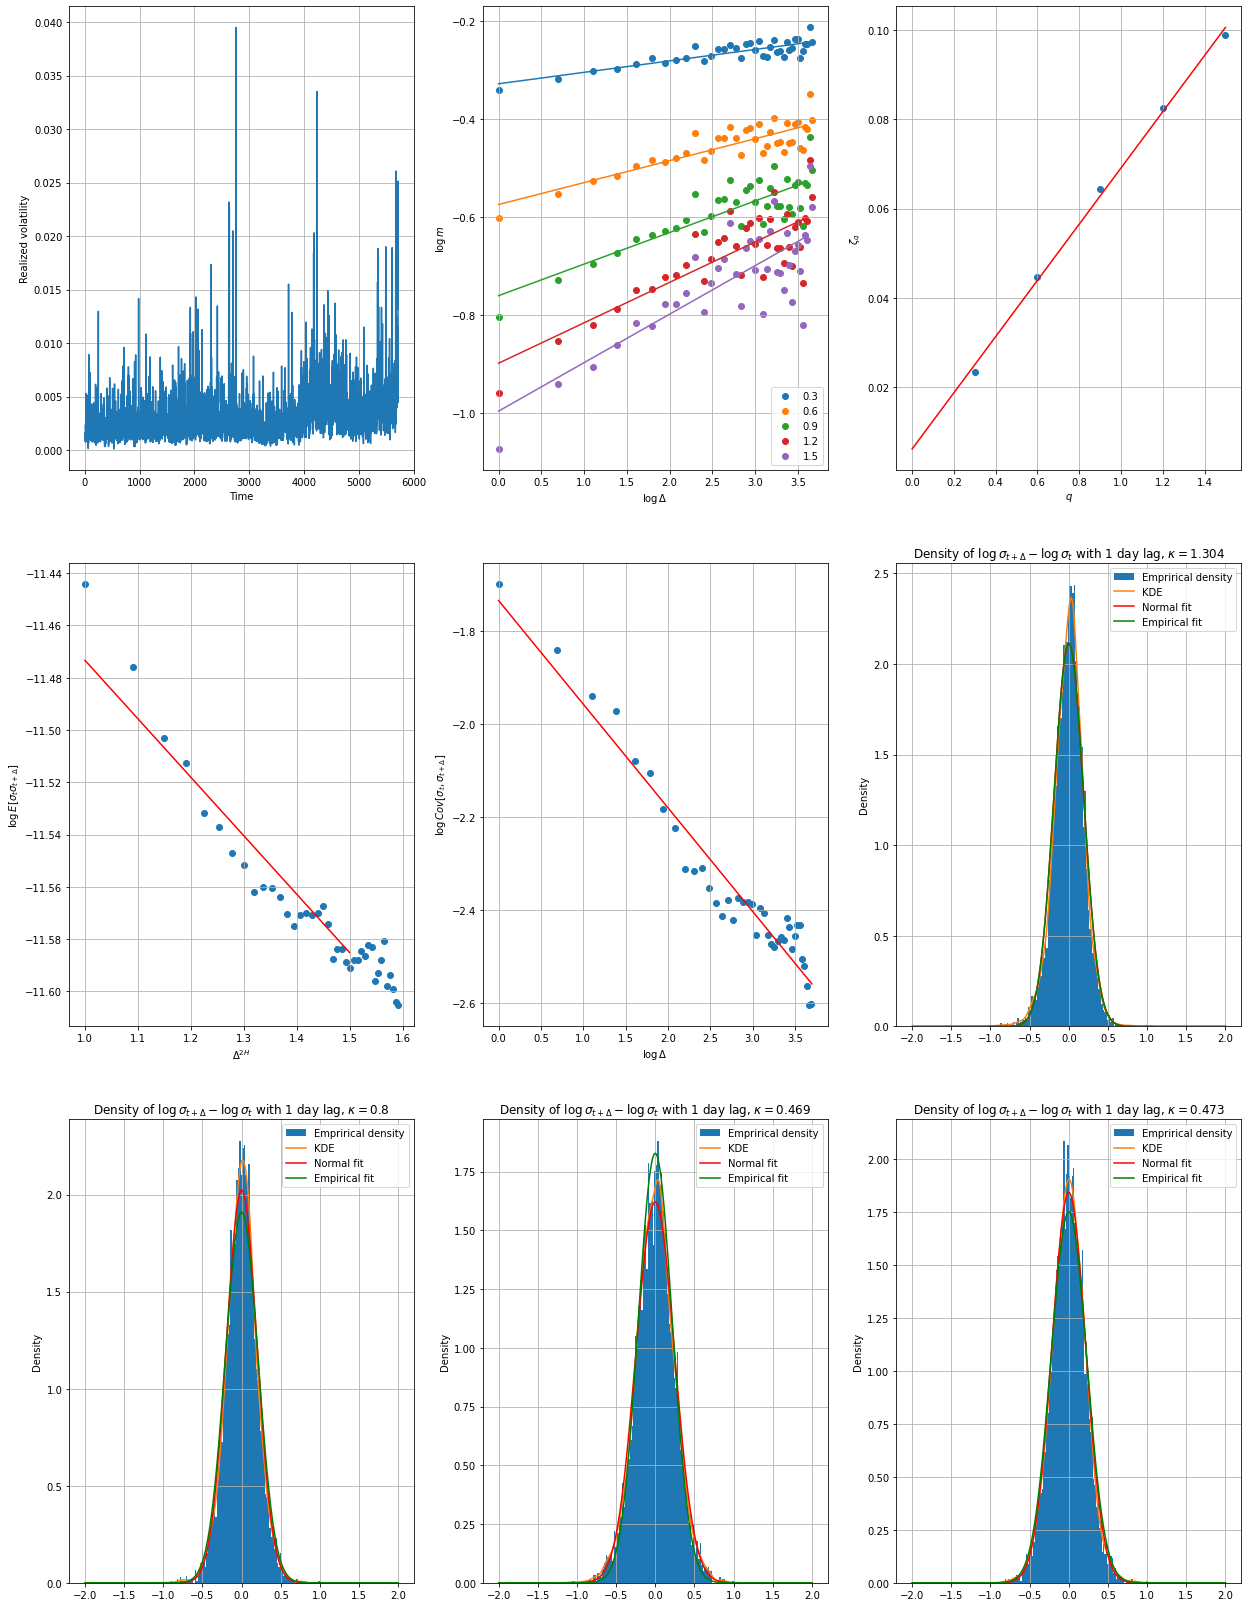

C:\Users\Artemy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Report on OGZD LI Equity
Estimated H parameter for OGZD LI Equity is equal to 0.05239812593133651


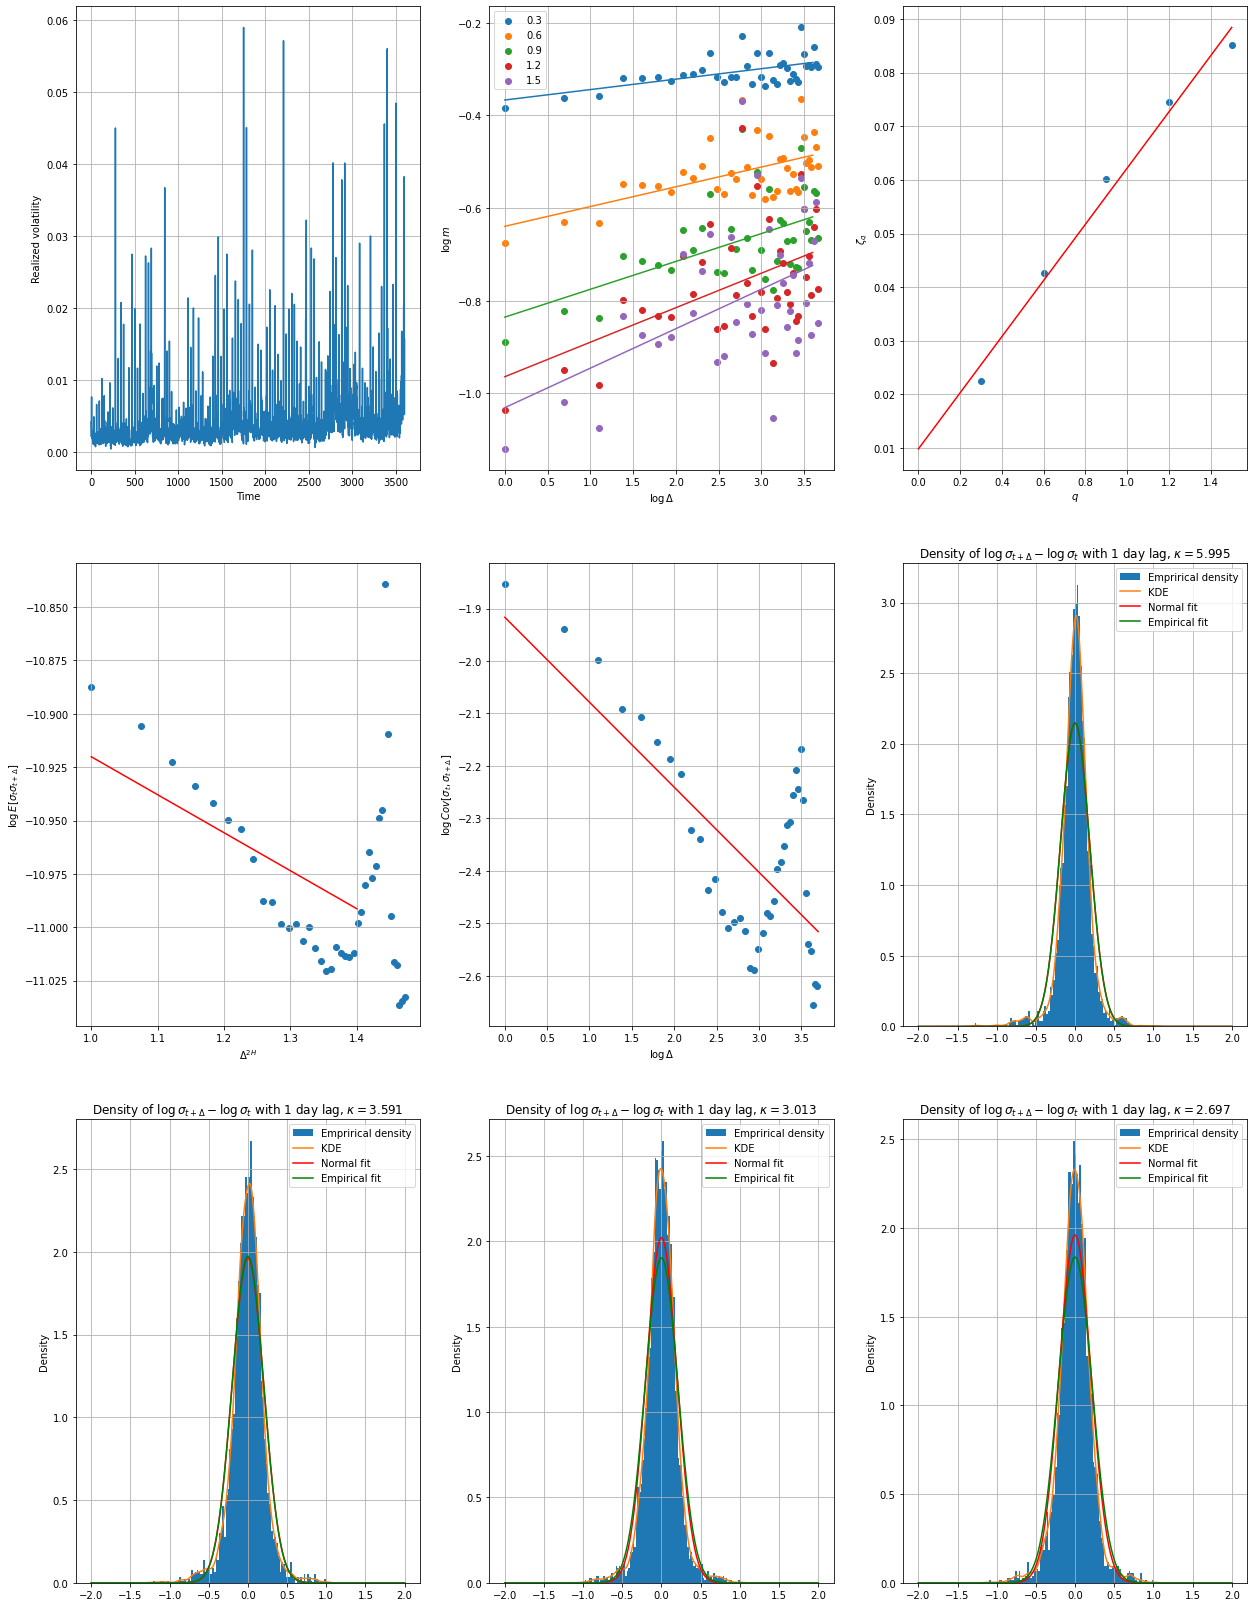

Report on VTBR LI Equity
Estimated H parameter for VTBR LI Equity is equal to 0.037018488968775666


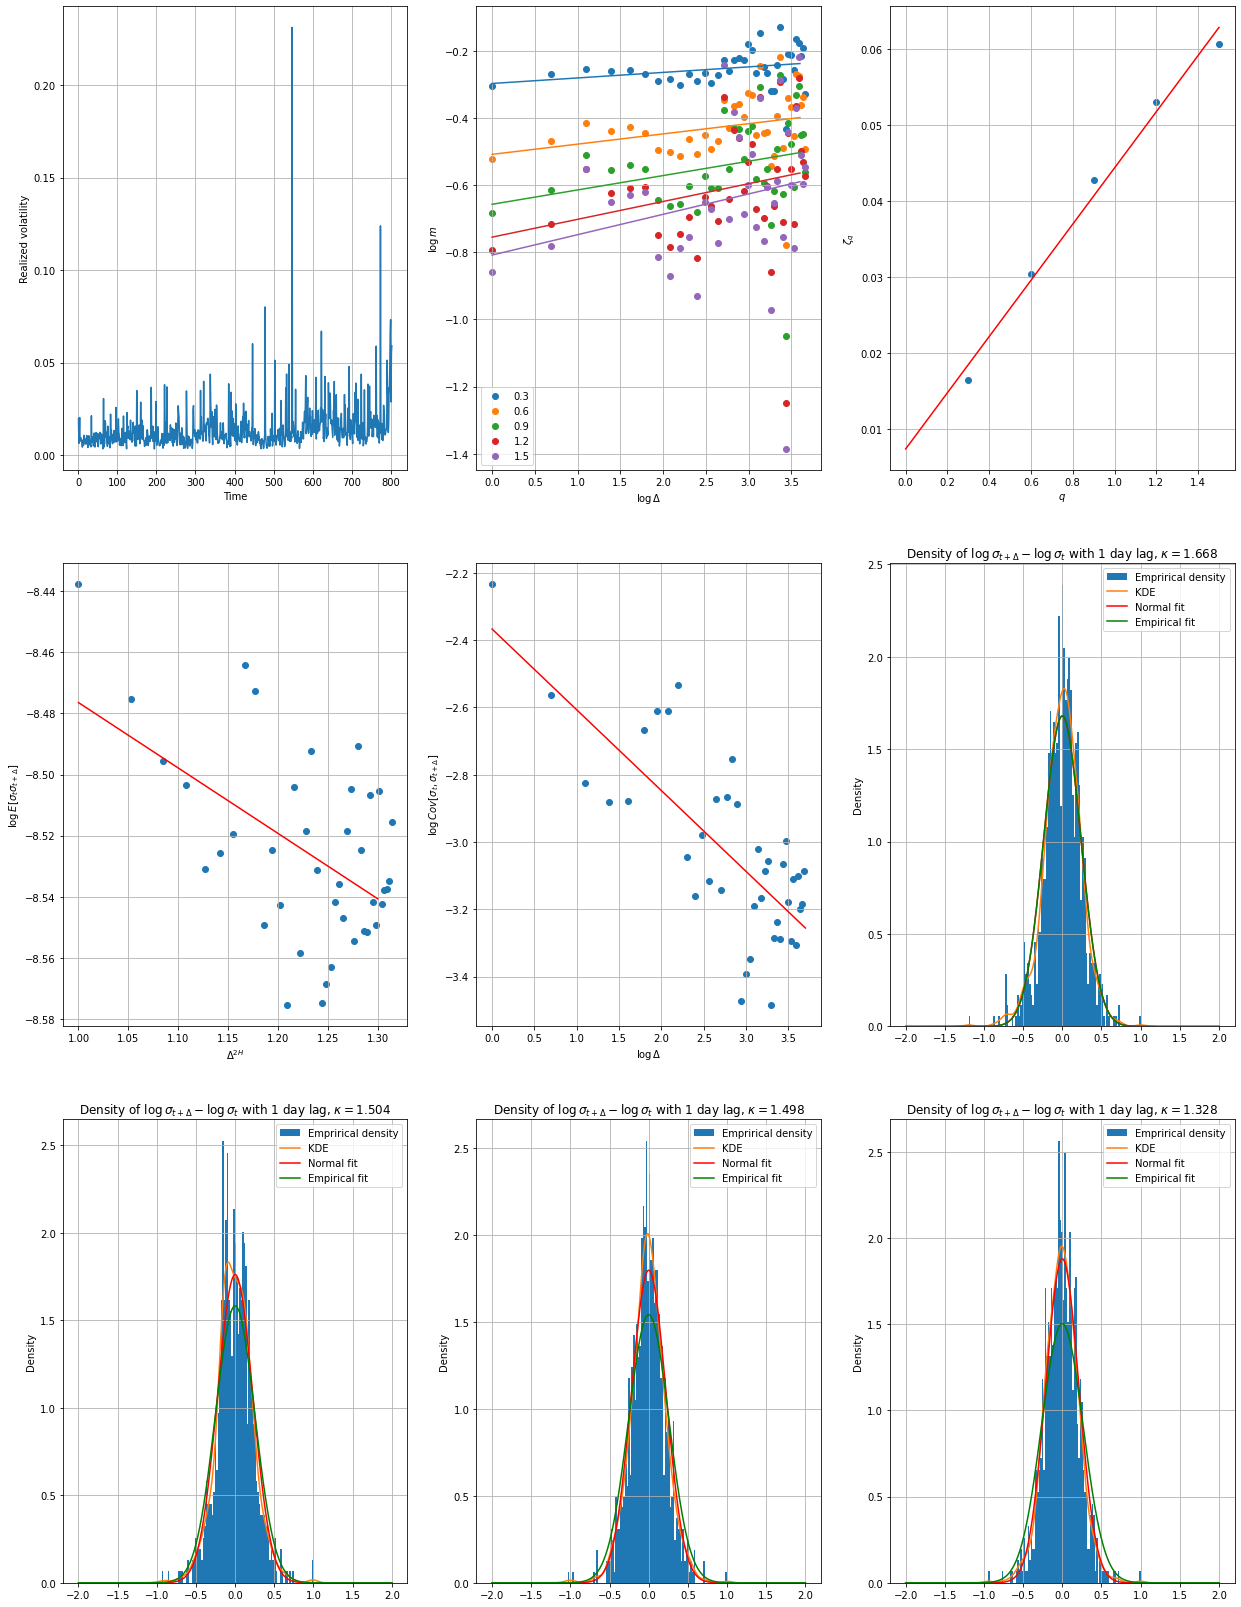

Report on SBER LI Equity
Estimated H parameter for SBER LI Equity is equal to 0.057805332787297735


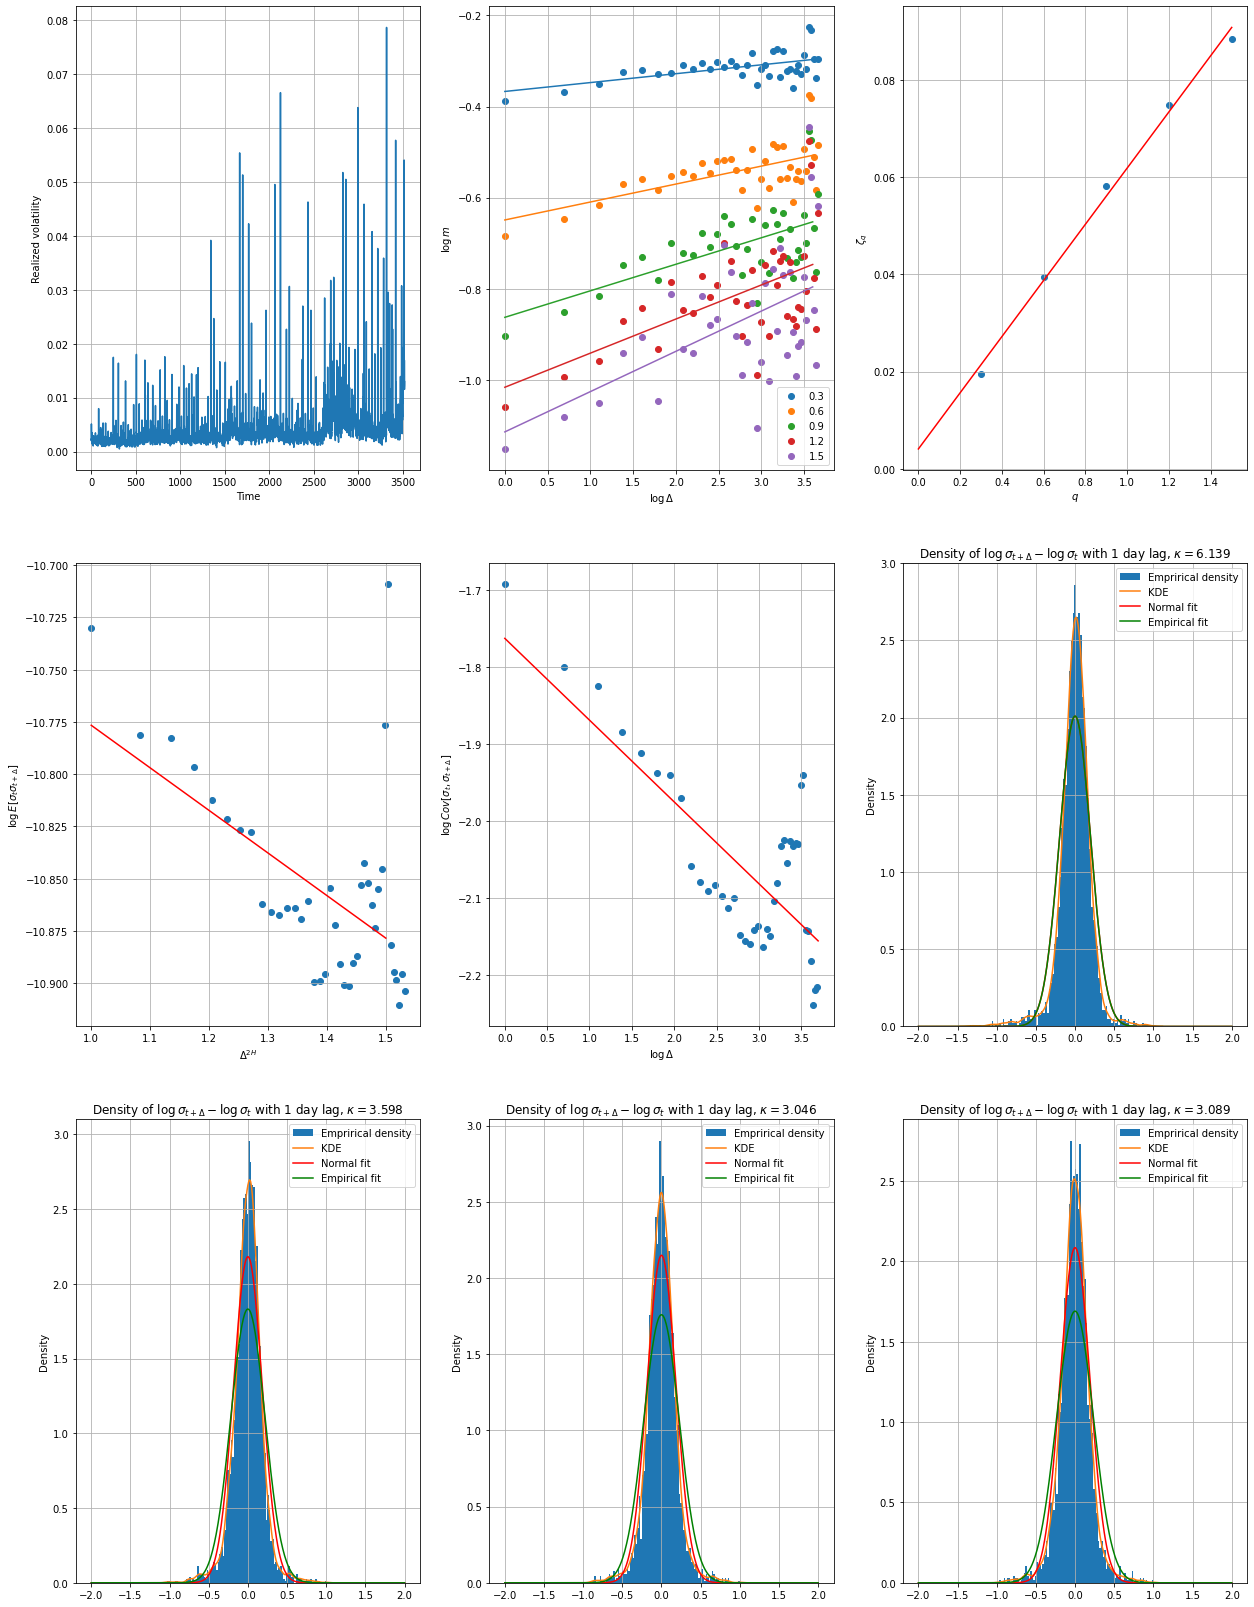

Report on LKOD LI Equity
Estimated H parameter for LKOD LI Equity is equal to 0.035279213491720085


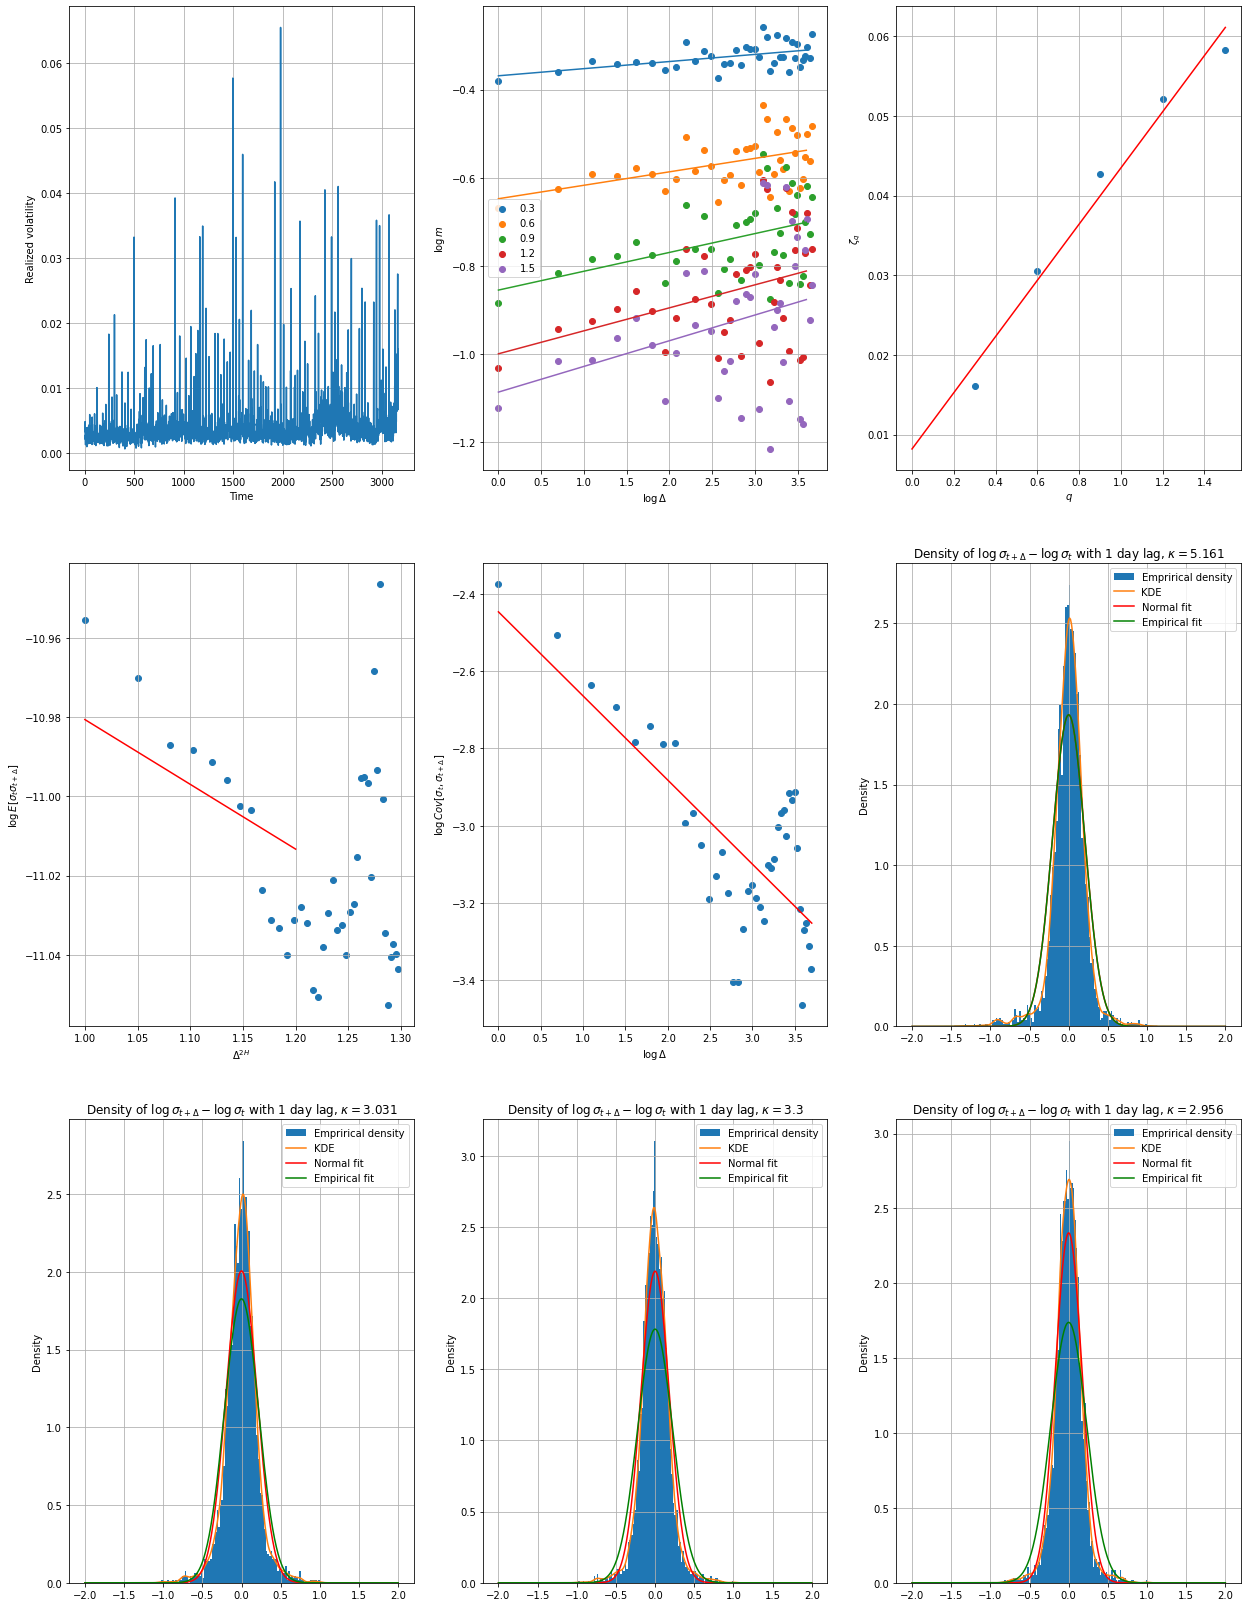

In [7]:
for name in Equities:
    analyse_volatility(name, mode='bb', save_pics=True)

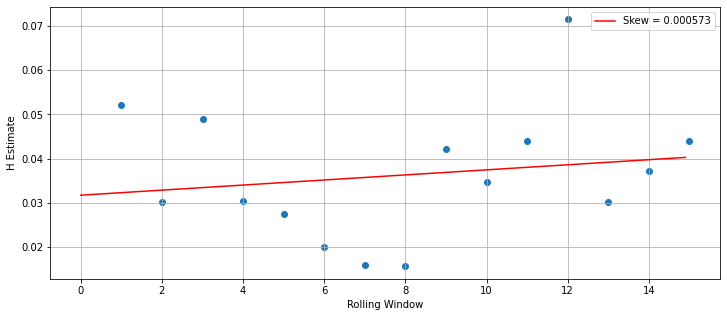

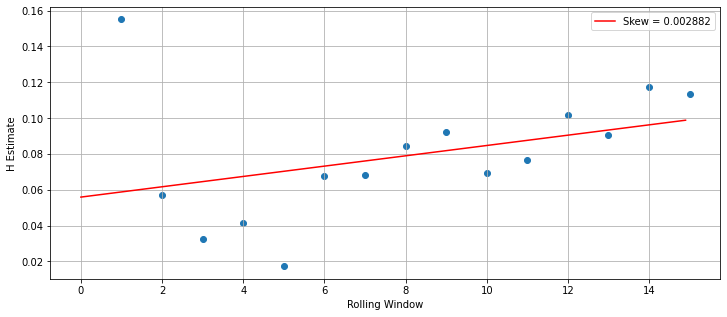

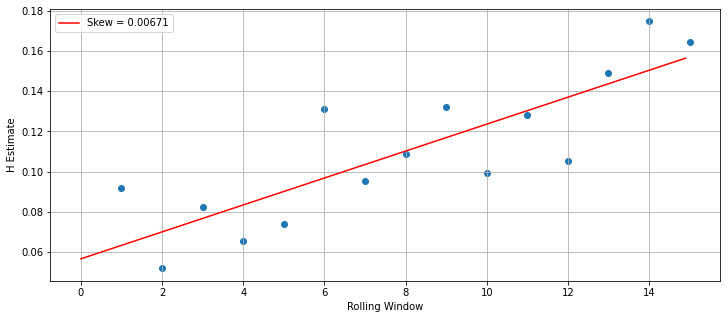

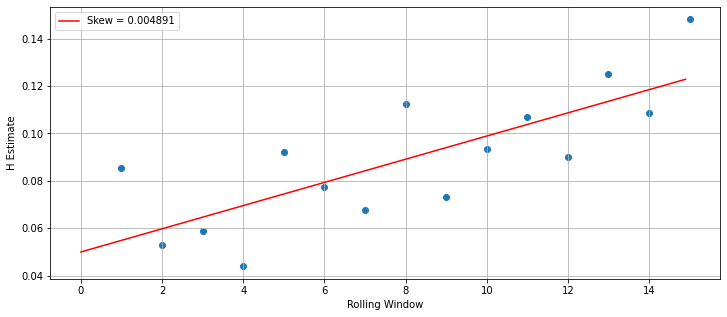

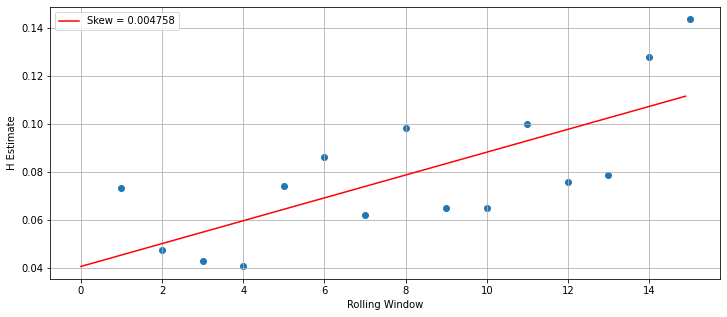

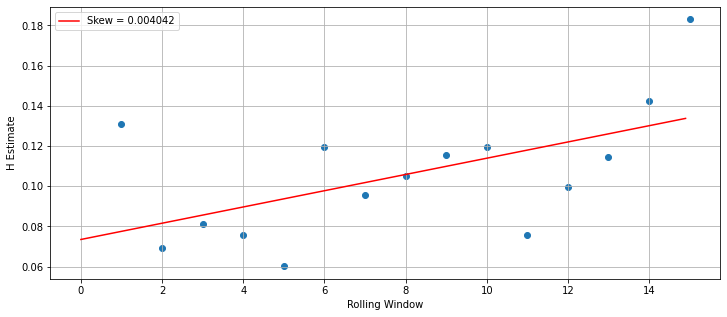

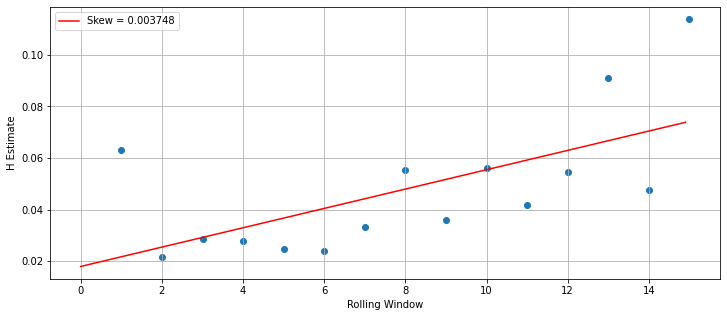

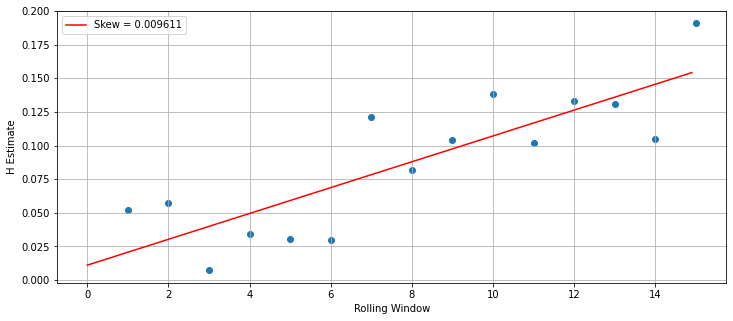

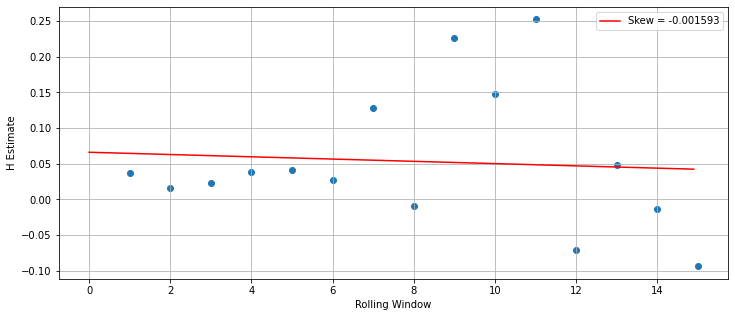

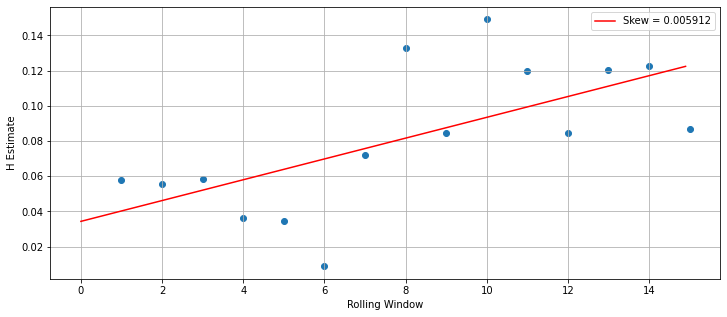

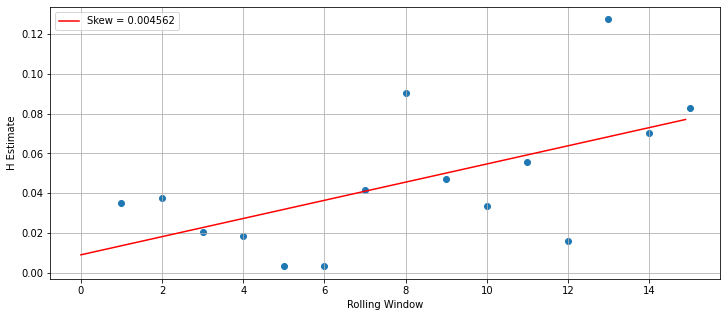

In [10]:
for name in Equities:
    smoothing_empirical(name, count = minutes_count, save_pics=True)